<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Gillespie_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métricas

Consideraremos tiempos de ejecución para distintos tamaños y redes en el SIR markoviano.
Además, comparamos gráficamente trayectorias markovianas con ambos algoritmos, es decir, utilizando el algoritmo para redes markovianas, y el algoritmo para redes no markovianas, usando distribuciones exponenciales y cercanas a una exponencial, de la familia Weibull.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [4]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index


In [5]:
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return Historia

#### Red Poisson $N=5\cdot 10^3$, con media $n=N\cdot 0.1$.
#### $\beta=1.25$, $\gamma=1$
#### Condición inicial $X(0)=(N-1,1,0)$

--- 63.5496940612793 Segundos para crear la gráfica ---
Empieza


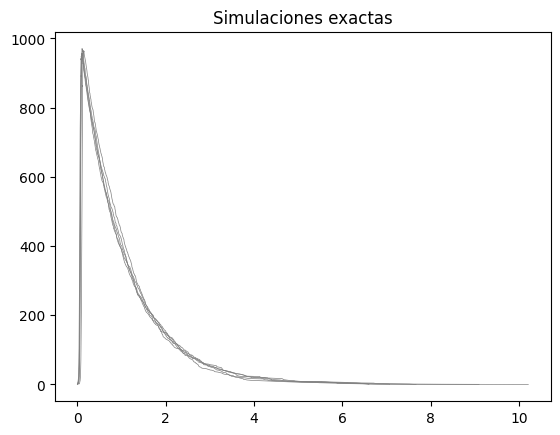

--- 4.094378709793091 Segundos para ejecutar ---
--- 67.64523077011108 Segundos en total ---


In [ ]:
import time
start_time = time.time()
N=10**3
n=int(N*0.1)
X_I_0=1
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))



#### Red Binomial $N=10^3$, con paámetro $p=0.1$.
#### $\beta=1.25$, $\gamma=1$
#### Condición inicial $X(0)=(N-1,1,0)$

--- 20.16082262992859 Segundos para crear la gráfica ---
Empieza
--- 78.66382002830505 Segundos para ejecutar 1 iteracion ---
--- 86.21764707565308 Segundos para ejecutar 1 iteracion ---
--- 83.84100842475891 Segundos para ejecutar 1 iteracion ---
--- 86.09617829322815 Segundos para ejecutar 1 iteracion ---
--- 85.02950119972229 Segundos para ejecutar 1 iteracion ---


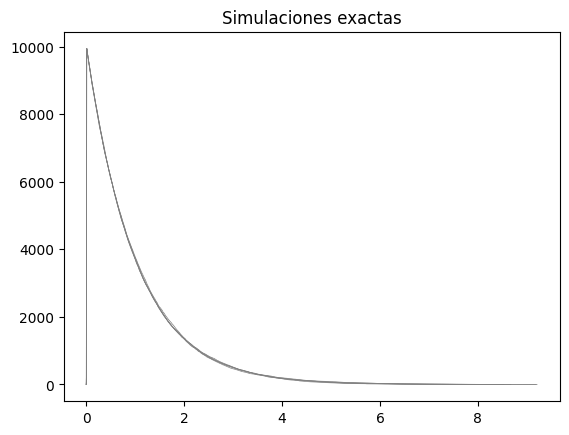

--- 607.3817899227142 Segundos para ejecutar ---
--- 627.543778181076 Segundos en total ---


In [ ]:
import time
start_time = time.time()
N=10**4
n=int(N*0.1)
X_I_0=1
G=nx.fast_gnp_random_graph(N,p=0.1)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))

Mismo algoritmo, pero removiendo vértices

--- 16.882884979248047 Segundos para crear la gráfica ---
Empieza
--- 84.36275863647461 Segundos para ejecutar 1 iteracion ---
--- 83.68527507781982 Segundos para ejecutar 1 iteracion ---
--- 82.46456623077393 Segundos para ejecutar 1 iteracion ---
--- 85.05274486541748 Segundos para ejecutar 1 iteracion ---
--- 84.21597003936768 Segundos para ejecutar 1 iteracion ---


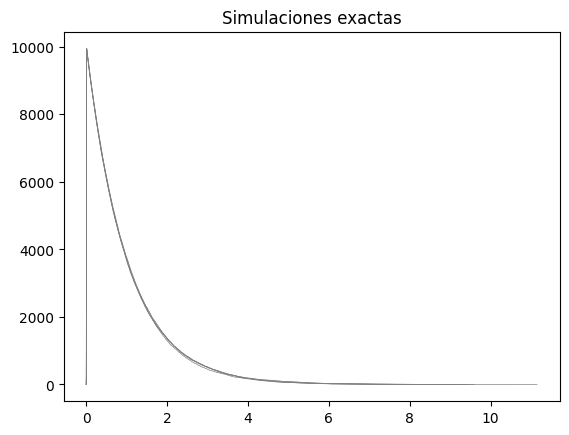

--- 599.3120279312134 Segundos para ejecutar ---
--- 616.1962261199951 Segundos en total ---


In [ ]:
def Gillespie_Direct_Method_Network_2(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
            G_network_initial.remove_node(i)
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return Historia
import time
start_time = time.time()
N=10**4
n=int(N*0.1)
X_I_0=1
G=nx.fast_gnp_random_graph(N,p=0.)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network_2(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))    
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))

### Conclusión: No se ve un cambio

Aumentando el orden promedio de los vértices se espera una diferencia mayor entre los algoritmos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

--- 0.0002155303955078125 Segundos para crear la gráfica ---
Empieza
--- 129.25775480270386 Segundos para ejecutar 1 iteracion ---
--- 122.83200001716614 Segundos para ejecutar 1 iteracion ---
--- 124.87604808807373 Segundos para ejecutar 1 iteracion ---
--- 121.9573302268982 Segundos para ejecutar 1 iteracion ---
--- 128.2326488494873 Segundos para ejecutar 1 iteracion ---


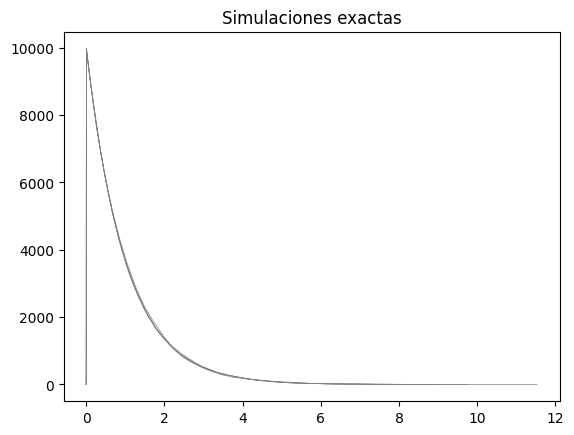

--- 956.4577744007111 Segundos para ejecutar ---
--- 956.4597132205963 Segundos en total ---


In [6]:
import time
start_time = time.time()
N=10**4
X_I_0=1
#G=nx.fast_gnp_random_graph(N,p=0.2)#-------------------------------------------------
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))

--- 146.50858521461487 Segundos para ejecutar 1 iteracion ---
--- 159.7005271911621 Segundos para ejecutar 1 iteracion ---
--- 192.16579031944275 Segundos para ejecutar 1 iteracion ---
--- 152.42947721481323 Segundos para ejecutar 1 iteracion ---


KeyboardInterrupt: ignored

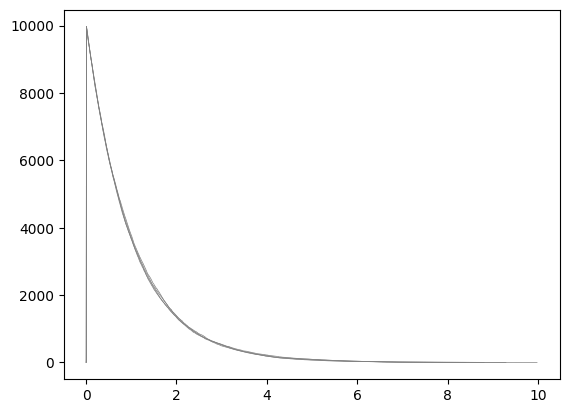

In [7]:
def Gillespie_Direct_Method_Network_2(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
            G_network_initial.remove_node(i)
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return Historia
import time
start_time = time.time()
N=10**4
X_I_0=1
#G=nx.fast_gnp_random_graph(N,p=0.8)
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network_2(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))    
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))

In [ ]:
#Codigo para testear el fsolve().
t_j=[np.random.exp(0.5) for j in range(10)]
print(t_j)
M_1=6
M_2=10-M_1
a_I=1.2
a_R=1.2
L_I=1.25
L_R=1
u=np.uniform()
def f_to_solve(x):
    S_1=np.sum([(x+t_j[i])**(a_I) for i in range(M_1)])
    S_2=np.sum([(x+t_j[i])**(a_I) for i in range(M_1,M_2+M_1)])
    S_3=np.sum([t[i]**a_I for i in range(M_1)])
    S_4=np.sum([t[i]**a_R for i in range(M_1,M_1+M_2)])
    return (S_1+S_2+np.log(u)-(L_I**a_I+L_R**a_R))

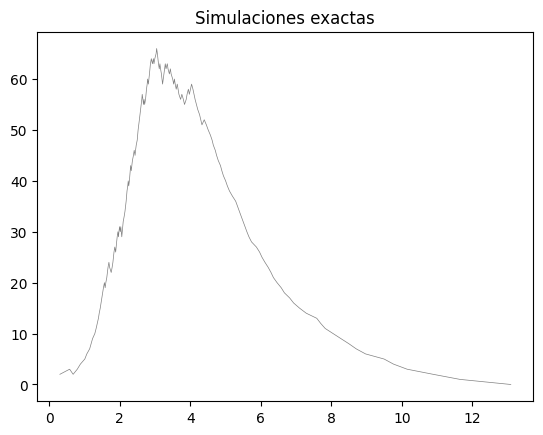

In [51]:
from scipy.optimize import fsolve
import networkx as nx
tipo=''
if(tipo=='completa'):
    N=8
    G=nx.complete_graph(N)
    pos=nx.spring_layout(G,seed=2)
else:
    N=100
    n=int(N*0.1)
    ksum=1
    np.random.seed(2)
    while(ksum%2!=0):#Que defina una grafica.
            k_dist=np.random.poisson(n,size=N)
            ksum=sum(k_dist)
    G=nx.random_degree_sequence_graph(k_dist)
    pos=nx.spring_layout(G,seed=2,k=3)
X_I_indexes=[0]
X_I=len(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
#nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
lammbda_I=1.25
a_I=1.2
lammbda_R=1
a_R=1.2
def pdf_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_I(x,lammbda=lammbda_I,a=a_I):
    return np.exp(-(lammbda*x)**(a))
def pdf_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    # a=1 es una exponencial.
    return (lammbda*a)*(lammbda*x)**(a-1)*np.exp(-(lammbda*x)**(a))
def survival_Weibull_R(x,lammbda=lammbda_R,a=a_R):
    return np.exp(-(lammbda*x)**(a))
### Algoritmo 
#Paso 1.
t=0
aristas_en_riesgo={'arista':[],'tiempo':[]}
vertices_infecciosos={'vertice':[],'tiempo':[]}
#Llenar estos arreglos.
#N es el número de individuos.
for j in X_I_indexes:
    vertices_infecciosos['vertice'].append(j)
    vertices_infecciosos['tiempo'].append(0)
    for i in range(N):
        if G.has_edge(i,j):
            aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))
            aristas_en_riesgo['tiempo'].append(0) 
flag=True
#---------------------------
count=0
Tuto=False
hist=[]
tau=0.5
while(flag):
    #print(aristas_en_riesgo['tiempo'])
    #print(vertices_infecciosos['tiempo'])
    count+=1
    #Paso 2.
    #Definir \\Phi(\\tau|\\{t_j\\}):

    #---------------------------

    #----------------------------
    #Paso 3.
    #Generar el tiempo de siguiente reaccion:
    u=np.random.uniform()
    def f_to_solve(x):
        S_1=np.sum([(x+r)**(a_I) for r in aristas_en_riesgo['tiempo']])
        S_2=np.sum([(x+r)**(a_I) for r in vertices_infecciosos['tiempo']])
        S_3=np.sum([r**a_I for r in aristas_en_riesgo['tiempo']])
        S_4=np.sum([r**a_R for r in vertices_infecciosos['tiempo']])
        return (S_1+S_2+np.log(u)-(lammbda_I**a_I+lammbda_R**a_R)-S_3-S_4)
    try:
        tau=fsolve(func=f_to_solve,x0=tau/5)
    except:
        print("Error in fsolve")
        if tau[2] in (1,2,3): #,4,5):
            print("Ocurre error 1 2 3")
            # 4,5 means \"not making good progress\" (see fsolve docstring)
            xinf_val = float(tau[0])
        else:
            print("Nt making good progress")
    if(tau<0):
        print("Epale")
    tau=tau[0]
    t+=tau
    #-------------------------
    #Paso 4. 
    #Definir las cantidades $\\phi(\\tau,i|t_i) 
    #Paso 5.
    #Calcular las probabilidades $\\Pi_j$
    pi_s_teoricas=[]
    for j in range(len(aristas_en_riesgo['tiempo'])):
        pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
    for j in range(len(vertices_infecciosos['tiempo'])):
        pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
    pi_s=pi_s_teoricas/np.sum(pi_s_teoricas)
    #Paso 6.
    #Decidir el canal de reacción.
    u_2=np.random.uniform()
    D=pi_s[0]
    k=0
    while(u_2>D):
        k+=1
        D+=pi_s[k]
    #print(k,\" es el canal de reaccion seleccionado.\")
    #--------------------------------
    #Paso 7 y 8.
    #Actualizacion de tiempos DESDE la ultima reaccion (en todos los canales)
    aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
    vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
    #------------
    #Identificar la reaccion
    if(k<len(aristas_en_riesgo['tiempo'])):#Infeccion
        reaccion='infeccion'
        X_I+=1
        #arista
        arista_elegida=aristas_en_riesgo['arista'][k]
        involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
        #Identificar al nuevo infectado-------------
        if(G.nodes[involucrado_1]['Estado:']=='Susceptible'):
            #involucrado_1 es el nuevo infeccioso
            nuevo_infectado=involucrado_1
        else:
            nuevo_infectado=involucrado_2
        G.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
        #--------------------------
        #Agregarlo a la lista vertices_infecciosos con tiempo 0----
        vertices_infecciosos['vertice'].append(nuevo_infectado)
        vertices_infecciosos['tiempo'].append(0)
        #-----------------------------
        #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.\n",
        for nei in G.neighbors(nuevo_infectado):
            if(G.nodes[nei]['Estado:']=='Susceptible'):
                aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
                aristas_en_riesgo['tiempo'].append(0)
            else:
                if(G.nodes[nei]['Estado:']=='Infeccioso'):
                    index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
                    aristas_en_riesgo['arista'].pop(index)
                    aristas_en_riesgo['tiempo'].pop(index)
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a la arista que provocó la nueva infeccion

        #-----------------------------
        nuevo_involucrado=nuevo_infectado
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a las aristas que ya no son viables. I.e. involucra a dos infecciosos.
        #-----------------------------
    else:#Recuperacion.
        X_I-=1
        reaccion='recuperacion'
        indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])
        nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
        #Actualiza el estado a Recuperado.
        G.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
        #-----------------------------
        #Elimina de la lista vertices_infecciosos al nuevo recuperado.
        vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
        vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
        #-----------------------------
        #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
        aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
        count=-1
        for l in range(len(aristas_en_riesgo_copia)):
            edge=aristas_en_riesgo_copia[l]
            if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
                count+=1
                aristas_en_riesgo['arista'].pop(l-count)
                aristas_en_riesgo['tiempo'].pop(l-count)
        #-----------------------------
        nuevo_involucrado=nuevo_recuperado
    if(Tuto):
        print("-"*30)
        print("En la siguiente iteración ocurre: \\n \\t *Se genera el tiempo "+str(tau)+"\\n\\t *Se selecciona el canal " +str(k)+ ", que significa "+reaccion+" del individuo " +str(nuevo_involucrado))
        print("-"*30)
        print("\\n La grafica se ve asi: ")
        nx.draw(G, pos,with_labels=True,node_color=['r' if G.nodes[i]['Estado:']=='Infeccioso' else 'g' if G.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
        plt.show()
    else:
        hist.append([t,X_I])
    if(X_I==0):
        flag=False
H=pd.DataFrame(hist,columns=['time','I(t)'])
plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()

In [28]:
aristas_prob=[0.4339845425471257, 0.4339845425471257, 0.4339845425471257, 0.279802224121271, 0.279802224121271, 0.279802224121271, 0.279802224121271, 0.279802224121271, 0.2514670680822316, 0.2514670680822316, 0.2514670680822316, 0.2514670680822316, 0.2514670680822316, 0.2514670680822316, 0.2514670680822316, 0.2514670680822316, 0.2416996247125333, 0.2416996247125333, 0.2416996247125333, 0.2416996247125333, 0.2416996247125333, 0.2416996247125333, 0.2416996247125333, 0.16222765558638433, 0.16222765558638433, 0.16222765558638433, 0.16222765558638433, 0.16222765558638433, 0.16222765558638433, 0.16222765558638433, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.1560015979598805, 0.11527506175215745, 0.11527506175215745, 0.11527506175215745, 0.11527506175215745, 0.11043335077791584, 0.11043335077791584, 0.11043335077791584, 0.11043335077791584, 0.11043335077791584, 0.11043335077791584, 0.11043335077791584, 0.10383066468319276, 0.10383066468319276, 0.10383066468319276, 0.10383066468319276, 0.10383066468319276, 0.10383066468319276, 0.10383066468319276, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.0668966236359155, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.058110006133355985, 0.051519791886794744, 0.051519791886794744, 0.051519791886794744, 0.051519791886794744, 0.051519791886794744, 0.04310488714273736, 0.04310488714273736, 0.04310488714273736, 0.04277984914608718, 0.04277984914608718, 0.04277984914608718, 0.04277984914608718, 0.04277984914608718, 0.04277984914608718, 0.04277984914608718, 0.04277984914608718, 0.03243858669558216, 0.03243858669558216, 0.03243858669558216, 0.03243858669558216, 0.03243858669558216, 0.03243858669558216, 0.02749369498834852, 0.02749369498834852, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.02102648731452601, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.017198977575358466, 0.004965429171845669, 0.004965429171845669, 0.004965429171845669, 0.004965429171845669, 0.004965429171845669]
vertices_prob=[0.4339845425471257, 0.279802224121271, 0.2514670680822316, 0.2416996247125333, 0.16222765558638433, 0.1560015979598805, 0.11527506175215745, 0.11043335077791584, 0.10383066468319276, 0.0668966236359155, 0.058110006133355985, 0.051519791886794744, 0.04310488714273736, 0.04277984914608718, 0.03243858669558216, 0.02749369498834852, 0.02102648731452601, 0.017198977575358466, 0.004965429171845669]


In [44]:
max(aristas_prob)

0.4339845425471257

In [48]:
a_I=1.2
a_R=1.2
lammbda_I=1.25
lammbda_R=1.0
def Phi(tau):######Creo que se puede optimizar.
        Sum_1=np.sum([(tau+x)**a_I for x in aristas_prob])
        Sum_2=np.sum([x**a_R-(tau+x)**a_R for x in vertices_prob])
        return np.exp((lammbda_I**(a_I))*(Sum_1)+(lammbda_R**(a_R))*Sum_2)
u=np.random.uniform()
def f_to_solve(x):
    S_1=np.sum([(x+r)**(a_I) for r in aristas_prob])
    S_2=np.sum([(x+r)**(a_I) for r in vertices_prob])
    S_3=np.sum([r**a_I for r in aristas_prob])
    S_4=np.sum([r**a_R for r in vertices_prob])
    return (S_1+S_2+np.log(u)-(lammbda_I**a_I+lammbda_R**a_R)-S_3-S_4)
tau=fsolve(func=f_to_solve,x0=1/5)

In [49]:
tau

array([0.0260299])

In [ ]:
t_j=[np.random.exp(0.5) for j in range(10)]
print(t_j)
M_1=6
M_2=10-M_1
a_I=1.2
a_R=1.2
L_I=1.25
L_R=1
u=np.uniform()
def f_to_solve(x):
    S_1=np.sum([(x+t_j[i])**(a_I) for i in range(M_1)])
    S_2=np.sum([(x+t_j[i])**(a_I) for i in range(M_1,M_2+M_1)])
    S_3=np.sum([t[i]**a_I for i in range(M_1)])
    S_4=np.sum([t[i]**a_R for i in range(M_1,M_1+M_2)])
    return (S_1+S_2+np.log(u)-(L_I**a_I+L_R**a_R))